In [19]:
!pip install sodapy
!pip install feather-format
import pandas as pd
import numpy as np
from sodapy import Socrata
import collections;
import re;
from time import time
import math
import feather
from collections import defaultdict
import seaborn as sns
sns.set(context="poster", style="ticks")

In [4]:
# Load SF Police Data
df = feather.read_dataframe('./data/sf_incidents.feather')
print(df.shape)
df.head()

(695366, 7)


,incident_date,incident_dow,incident_number,incident_time,latitude,longitude,incident_type
0,2018-12-02,Sunday,180908554,00:45,37.784908299430455,-122.40479506275997,b'other'
1,2018-12-01,Saturday,180908112,20:30,37.78640961281089,-122.40803623744476,b'other'
2,2019-03-18,Monday,190194129,14:01,37.75683373380551,-122.40669900268833,b'violent'
3,2019-03-20,Wednesday,190199583,08:00,37.784006612420036,-122.40486479517743,b'property'
4,2019-02-17,Sunday,196036034,22:45,37.80019018537176,-122.44117737724194,b'other'


In [5]:
df.incident_time = df.incident_time.astype(str)
df.incident_time = df.incident_time + ':00'
df.incident_date = df.incident_date.astype(str)

In [6]:
import datetime as dte
df["incident_datetime"] =pd.to_datetime( df["incident_date"] + ' ' + df['incident_time'])

In [7]:
df.head()

,incident_date,incident_dow,incident_number,incident_time,latitude,longitude,incident_type,incident_datetime
0,2018-12-02,Sunday,180908554,00:45:00,37.784908299430455,-122.40479506275997,b'other',2018-12-02 00:45:00
1,2018-12-01,Saturday,180908112,20:30:00,37.78640961281089,-122.40803623744476,b'other',2018-12-01 20:30:00
2,2019-03-18,Monday,190194129,14:01:00,37.75683373380551,-122.40669900268833,b'violent',2019-03-18 14:01:00
3,2019-03-20,Wednesday,190199583,08:00:00,37.784006612420036,-122.40486479517743,b'property',2019-03-20 08:00:00
4,2019-02-17,Sunday,196036034,22:45:00,37.80019018537176,-122.44117737724194,b'other',2019-02-17 22:45:00


In [8]:
import random
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/var/pyenv/versions/3.7.2/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


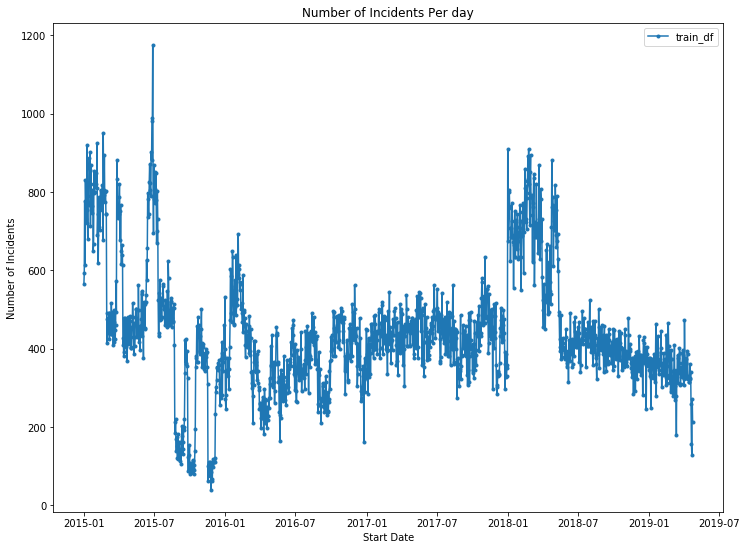

In [9]:
plt.figure(figsize=(12, 9))

# Make a temporary copy of our datasets
tmp_train = df.copy()
tmp_train['date'] = tmp_train['incident_datetime'].dt.date
tmp_train = tmp_train.groupby('date').count()['incident_number']

# Plot the temporal overlap
plt.plot(tmp_train, '.-', label='train_df')

plt.title('Number of Incidents Per day')
plt.xlabel("Start Date")
plt.legend()
plt.ylabel('Number of Incidents');

In [10]:
def add_time_columns(df):
    """
    Add temporal features to df
    """
    df.is_copy = False 
    df.loc[:, 'month'] = df['incident_datetime'].dt.month
    df.loc[:, 'week_of_year'] = df['incident_datetime'].dt.weekofyear
    df.loc[:, 'day_of_month'] = df['incident_datetime'].dt.day
    df.loc[:, 'day_of_week'] = df['incident_datetime'].dt.dayofweek
    df.loc[:, 'hour'] = df['incident_datetime'].dt.hour
    df.loc[:, 'week_hour'] = df['incident_datetime'].dt.weekday * 24 + df['hour']
 
    # No real need to return here, but we harmonize with remove_outliers for later pipelinezation
    return df

In [11]:
df_times = add_time_columns(df)
df_times.head()

/usr/local/var/pyenv/versions/3.7.2/lib/python3.7/site-packages/pandas/core/generic.py:5079: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/usr/local/var/pyenv/versions/3.7.2/lib/python3.7/site-packages/pandas/core/generic.py:5080: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


,incident_date,incident_dow,incident_number,incident_time,latitude,longitude,incident_type,incident_datetime,month,week_of_year,day_of_month,day_of_week,hour,week_hour
0,2018-12-02,Sunday,180908554,00:45:00,37.784908299430455,-122.40479506275997,b'other',2018-12-02 00:45:00,12,48,2,6,0,144
1,2018-12-01,Saturday,180908112,20:30:00,37.78640961281089,-122.40803623744476,b'other',2018-12-01 20:30:00,12,48,1,5,20,140
2,2019-03-18,Monday,190194129,14:01:00,37.75683373380551,-122.40669900268833,b'violent',2019-03-18 14:01:00,3,12,18,0,14,14
3,2019-03-20,Wednesday,190199583,08:00:00,37.784006612420036,-122.40486479517743,b'property',2019-03-20 08:00:00,3,12,20,2,8,56
4,2019-02-17,Sunday,196036034,22:45:00,37.80019018537176,-122.44117737724194,b'other',2019-02-17 22:45:00,2,7,17,6,22,166


In [12]:
train_copy = df_times

In [13]:
df = train_copy[['hour',"day_of_week"]]

df["weekday"] = df.day_of_week.apply(lambda x: 'yes' if 0 < x < 6 else 'no')

df = df.replace({ "day_of_week":{0:'Sun', 1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5:'Fri',6:'Sat'}, 
                   })
x = df[df['weekday'] == 'yes']
y = df[df['weekday'] == 'no']

/usr/local/var/pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


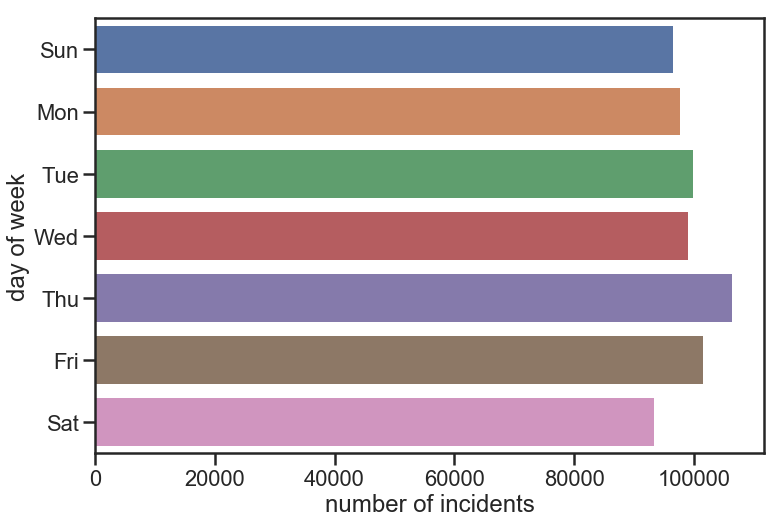

In [34]:
# Visualization 1
fig, ax = plt.subplots(figsize=(12,8))

sns.countplot(y="day_of_week", order=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"], data=df, ax=ax)

plt.xlabel("number of incidents")
plt.ylabel("day of week")

# plt.legend()
plt.savefig("./figures/day_of_week_crime.png", dpi=300)

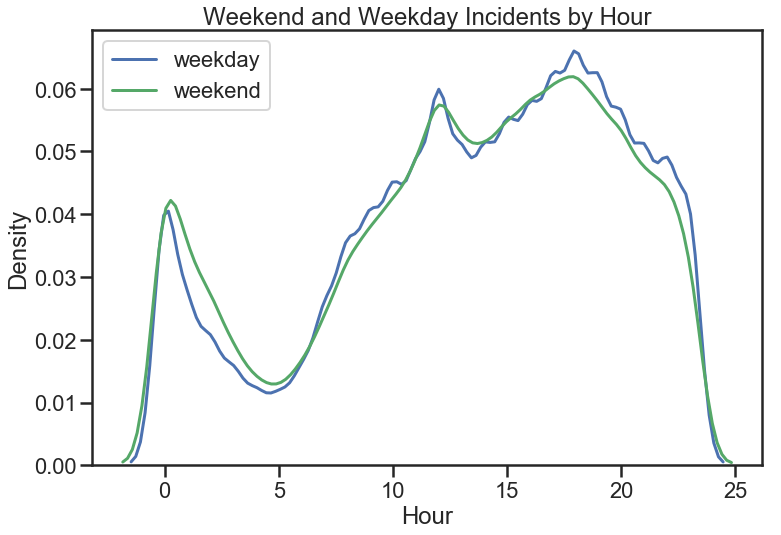

In [33]:
# Visualization 2
# x = sns.distplot(df, kde=True, rug=False, color = 'b', label = 'weekday riders' )
# y = sns.distplot(daily_counts['registered'], kde=True, rug=False, color='g', label = 'weekend riders')


#sns.lineplot(df['hour'], df[df['weekday'] == 'yes'], label = 'casual')

fig, ax = plt.subplots(figsize=(12,8))

sns.distplot(df[df['weekday'] == 'yes']["hour"], hist = False, kde=True, rug=False, color = 'b', label = 'weekday', ax=ax)
sns.distplot(df[df['weekday'] == 'no']["hour"], hist = False, kde=True, rug=False, color = 'g', label = 'weekend', ax=ax)


#y = sns.distplot(daily_counts['registered'], kde=True, rug=False, color='g', label = 'registered')



plt.xlabel("Hour")
plt.ylabel("Density")
plt.title('Weekend and Weekday Incidents by Hour')
plt.legend()
plt.savefig("./figures/hourly_incident.png", dpi=300)

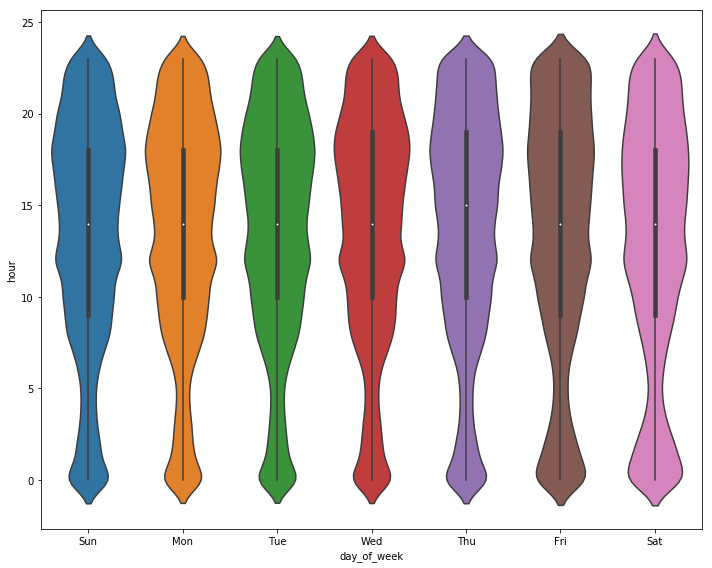

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(10, 8))
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

#YOUYR CODE EHAERAE

ax = sns.violinplot(y="hour", x="day_of_week",order=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"], data=df)

plt.tight_layout();